<b>Problem statement: 
To build a CNN based model which can accurately detect melanoma. Melanoma is a type of cancer that can be 

deadly if not detected early. It accounts for 75% of skin cancer deaths. A solution which can evaluate images and alert the 

dermatologists about the presence of melanoma has the potential to reduce a lot of manual effort needed in diagnosis.<b>



### import all libraries

In [1]:
import pathlib
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os
import PIL
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential

In [2]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [3]:
!unzip gdrive/MyDrive/CNN_assignment.zip

Archive:  gdrive/MyDrive/CNN_assignment.zip
  inflating: Skin cancer ISIC The International Skin Imaging Collaboration/Test/actinic keratosis/ISIC_0010512.jpg  
  inflating: Skin cancer ISIC The International Skin Imaging Collaboration/Test/actinic keratosis/ISIC_0010889.jpg  
  inflating: Skin cancer ISIC The International Skin Imaging Collaboration/Test/actinic keratosis/ISIC_0024468.jpg  
  inflating: Skin cancer ISIC The International Skin Imaging Collaboration/Test/actinic keratosis/ISIC_0024470.jpg  
  inflating: Skin cancer ISIC The International Skin Imaging Collaboration/Test/actinic keratosis/ISIC_0024511.jpg  
  inflating: Skin cancer ISIC The International Skin Imaging Collaboration/Test/actinic keratosis/ISIC_0024646.jpg  
  inflating: Skin cancer ISIC The International Skin Imaging Collaboration/Test/actinic keratosis/ISIC_0024654.jpg  
  inflating: Skin cancer ISIC The International Skin Imaging Collaboration/Test/actinic keratosis/ISIC_0024707.jpg  
  inflating: Skin ca

In [4]:
# Defining the path for train and test images
## Todo: Update the paths of the train and test dataset
path_to_train_directory="/content/gdrive/MyDrive/Skin cancer ISIC The International Skin Imaging Collaboration/Train"
path_to_test_directory="/content/gdrive/MyDrive/Skin cancer ISIC The International Skin Imaging Collaboration/Test"
data_dir_train = pathlib.Path(path_to_train_directory)
data_dir_test = pathlib.Path(path_to_test_directory)

In [5]:
!ls

 gdrive       'Skin cancer ISIC The International Skin Imaging Collaboration'
 sample_data


In [6]:
image_count_train = len(list(data_dir_train.glob('*/*.jpg')))
print(image_count_train)
image_count_test = len(list(data_dir_test.glob('*/*.jpg')))
print(image_count_test)

from glob import glob
path_list = list(data_dir_train.glob('*/*.jpg'))
print(path_list)

lesion_list = [os.path.basename((os.path.dirname(y))) for y in glob(os.path.join(data_dir_train, '*/*.jpg'))]
print(len(lesion_list))

dataframe_dict = dict(zip(path_list, lesion_list))

original_df = pd.DataFrame(list(dataframe_dict.items()),columns = ['Path','Label'])

2239
118
[PosixPath('/content/gdrive/MyDrive/Skin cancer ISIC The International Skin Imaging Collaboration/Train/vascular lesion/ISIC_0024662.jpg'), PosixPath('/content/gdrive/MyDrive/Skin cancer ISIC The International Skin Imaging Collaboration/Train/vascular lesion/ISIC_0024475.jpg'), PosixPath('/content/gdrive/MyDrive/Skin cancer ISIC The International Skin Imaging Collaboration/Train/vascular lesion/ISIC_0024669.jpg'), PosixPath('/content/gdrive/MyDrive/Skin cancer ISIC The International Skin Imaging Collaboration/Train/vascular lesion/ISIC_0024747.jpg'), PosixPath('/content/gdrive/MyDrive/Skin cancer ISIC The International Skin Imaging Collaboration/Train/vascular lesion/ISIC_0024706.jpg'), PosixPath('/content/gdrive/MyDrive/Skin cancer ISIC The International Skin Imaging Collaboration/Train/vascular lesion/ISIC_0024904.jpg'), PosixPath('/content/gdrive/MyDrive/Skin cancer ISIC The International Skin Imaging Collaboration/Train/vascular lesion/ISIC_0024867.jpg'), PosixPath('/conte

**Load using keras.preprocessing**

Let's load these images off disk using the helpful 
image_dataset_from_directory utility.

Create a dataset
Define some parameters for the loader:

In [7]:
batch_size = 32
img_height = 180
img_width = 180

Use 80% of the images for training, and 20% for validation.

In [8]:
## Write train dataset here
## Note use seed=123 while creating your dataset using tf.keras.preprocessing.image_dataset_from_directory
## Note, make sure your resize your images to the size img_height*img_width, while writting the dataset
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir_train,
  seed=123,
  validation_split = 0.2,
  subset = 'training',
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 2239 files belonging to 9 classes.
Using 1792 files for training.


In [9]:
## Write  validation dataset here
## Note use seed=123 while creating your dataset using tf.keras.preprocessing.image_dataset_from_directory
## Note, make sure your resize your images to the size img_height*img_width, while writting the dataset
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir_train,
  seed=123,
  validation_split = 0.2,
  subset = 'validation',
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 2239 files belonging to 9 classes.
Using 447 files for validation.


In [10]:
# List out all the classes of skin cancer and store them in a list. 
# You can find the class names in the class_names attribute on these datasets. 
# These correspond to the directory names in alphabetical order.
class_names = train_ds.class_names
print(class_names)

['actinic keratosis', 'basal cell carcinoma', 'dermatofibroma', 'melanoma', 'nevus', 'pigmented benign keratosis', 'seborrheic keratosis', 'squamous cell carcinoma', 'vascular lesion']


### **Visualize the data**

Todo, create a code to visualize one instance of all the nine classes present in the dataset

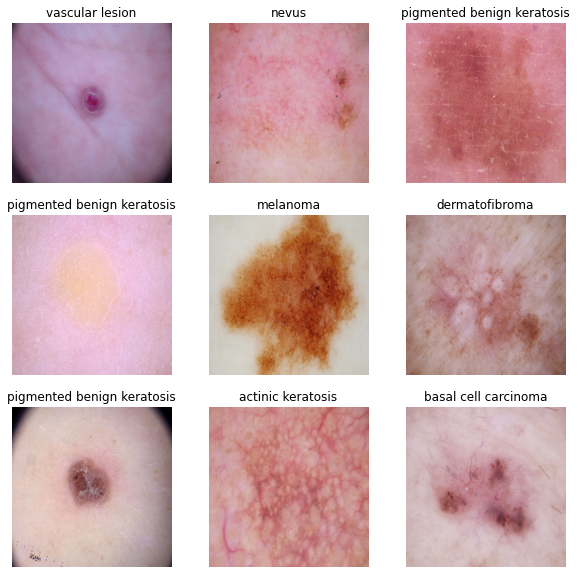

In [11]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")

### your code goes here, you can use training or validation data to visualize

In [12]:
#overlaps data preprocessing and model execution while training., Speed up training
AUTOTUNE = tf.data.experimental.AUTOTUNE
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

# **Create the model-1**

Create a CNN model, which can accurately detect 9 classes present in the dataset. Use layers.experimental.preprocessing.Rescaling to normalize pixel values between (0,1). The RGB channel values are in the [0, 255] range. This is not ideal for a neural network. Here, it is good to standardize values to be in the [0, 1].

In [13]:
### Your code goes here
num_classes = 9

model = Sequential([
  layers.experimental.preprocessing.Rescaling(1./255, input_shape=(img_height, img_width, 3)),
  layers.Conv2D(16, 3, padding='same', activation='relu'),
  #We slide over the feature map and extract tiles of a specified size. 
  layers.MaxPooling2D(),
  layers.Conv2D(32, 3, padding='same', activation='relu'),
  #We slide over the feature map and extract tiles of a specified size. 
  layers.MaxPooling2D(),
  layers.Conv2D(64, 3, padding='same', activation='relu'),
  #We slide over the feature map and extract tiles of a specified size. 
  layers.MaxPooling2D(),
  #Advantages of downsampling - Decreased size of input for upcoming layers, Works against overfitting
  layers.Flatten(),
  #Flattening - Convert into 1D feature vector.  Flattens all its structure to create a single long feature vector
  layers.Dense(128, activation='relu'),
  #Dense Layer - A dense layer represents a matrix vector multiplication.  each input node is connected to each output node.
  layers.Dense(num_classes)
  #Dense Layer - A dense layer represents a matrix vector multiplication.  each input node is connected to each output node.
])


# Compile the model

Choose an appropirate optimiser and loss function for model training

In [14]:
### Todo, choose an appropirate optimiser and loss function
#RMSprop. RMSprop is a very effective, but currently unpublished adaptive learning rate method
#Adam. Adam is a recently proposed update that looks a bit like RMSProp with momentum. The (simplified) update looks as follows:
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [15]:
# View the summary of all layers
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling (Rescaling)       (None, 180, 180, 3)       0         
                                                                 
 conv2d (Conv2D)             (None, 180, 180, 16)      448       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 90, 90, 16)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 90, 90, 32)        4640      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 45, 45, 32)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 45, 45, 64)        1

# Train the model-1

In [16]:
epochs = 20
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/20
56/56 [==============================] - 268s 1s/step - loss: 2.0432 - accuracy: 0.2243 - val_loss: 1.9201 - val_accuracy: 0.2774
Epoch 2/20
56/56 [==============================] - 3s 46ms/step - loss: 1.7889 - accuracy: 0.3594 - val_loss: 1.7779 - val_accuracy: 0.3400
Epoch 3/20
56/56 [==============================] - 3s 46ms/step - loss: 1.6336 - accuracy: 0.4074 - val_loss: 1.7297 - val_accuracy: 0.4183
Epoch 4/20
56/56 [==============================] - 3s 45ms/step - loss: 1.4368 - accuracy: 0.4983 - val_loss: 1.5550 - val_accuracy: 0.4989
Epoch 5/20
56/56 [==============================] - 3s 45ms/step - loss: 1.3368 - accuracy: 0.5190 - val_loss: 1.7742 - val_accuracy: 0.4497
Epoch 6/20
56/56 [==============================] - 3s 45ms/step - loss: 1.2408 - accuracy: 0.5698 - val_loss: 1.4009 - val_accuracy: 0.5391
Epoch 7/20
56/56 [==============================] - 3s 45ms/step - loss: 1.1075 - accuracy: 0.6021 - val_loss: 1.4387 - val_accuracy: 0.5436
Epoch 8/20
56

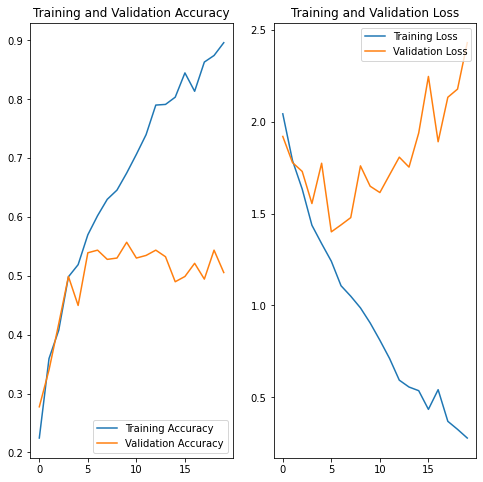

In [17]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

**Todo: Write your findings after the model fit, see if there is an evidence of model overfit or underfit**

**OBSERVATIONS:**
1.training datasety has accuracy 89%

2.validation set accuracy is 50%

3.model seems to be **overfitting**


# Create Model-2

In [18]:
### Your code goes here
num_classes = 9

model = Sequential([
  layers.experimental.preprocessing.Rescaling(1./255, input_shape=(img_height, img_width, 3)),
  layers.Conv2D(64, 3, padding='same', activation='relu'),
  #We slide over the feature map and extract tiles of a specified size. 
  layers.MaxPooling2D(),
  layers.Conv2D(128, 3, padding='same', activation='relu'),
  #We slide over the feature map and extract tiles of a specified size. 
  layers.MaxPooling2D(),
  layers.Conv2D(64, 3, padding='same', activation='relu'),
  #We slide over the feature map and extract tiles of a specified size. 
  layers.MaxPooling2D(),
  #Advantages of downsampling - Decreased size of input for upcoming layers, Works against overfitting
  layers.Flatten(),
  #Flattening - Convert into 1D feature vector.  Flattens all its structure to create a single long feature vector
  layers.Dense(128, activation='relu'),
  #Dense Layer - A dense layer represents a matrix vector multiplication.  each input node is connected to each output node.
  layers.Dense(num_classes)
  #Dense Layer - A dense layer represents a matrix vector multiplication.  each input node is connected to each output node.
])


# Compile model-2

In [19]:
### Todo, choose an appropirate optimiser and loss function
#RMSprop. RMSprop is a very effective, but currently unpublished adaptive learning rate method
#Adam. Adam is a recently proposed update that looks a bit like RMSProp with momentum. The (simplified) update looks as follows:
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

# Model-2 summary

In [20]:
# View the summary of all layers
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling_1 (Rescaling)     (None, 180, 180, 3)       0         
                                                                 
 conv2d_3 (Conv2D)           (None, 180, 180, 64)      1792      
                                                                 
 max_pooling2d_3 (MaxPooling  (None, 90, 90, 64)       0         
 2D)                                                             
                                                                 
 conv2d_4 (Conv2D)           (None, 90, 90, 128)       73856     
                                                                 
 max_pooling2d_4 (MaxPooling  (None, 45, 45, 128)      0         
 2D)                                                             
                                                                 
 conv2d_5 (Conv2D)           (None, 45, 45, 64)       

# Train model-2

In [21]:
epochs = 20
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/20
56/56 [==============================] - 9s 138ms/step - loss: 1.9549 - accuracy: 0.2835 - val_loss: 1.7022 - val_accuracy: 0.4116
Epoch 2/20
56/56 [==============================] - 7s 128ms/step - loss: 1.6666 - accuracy: 0.4035 - val_loss: 1.5527 - val_accuracy: 0.4653
Epoch 3/20
56/56 [==============================] - 7s 128ms/step - loss: 1.4853 - accuracy: 0.4704 - val_loss: 1.6049 - val_accuracy: 0.4452
Epoch 4/20
56/56 [==============================] - 7s 128ms/step - loss: 1.4177 - accuracy: 0.5156 - val_loss: 1.4142 - val_accuracy: 0.5190
Epoch 5/20
56/56 [==============================] - 7s 129ms/step - loss: 1.3133 - accuracy: 0.5285 - val_loss: 1.5576 - val_accuracy: 0.4653
Epoch 6/20
56/56 [==============================] - 7s 128ms/step - loss: 1.2141 - accuracy: 0.5647 - val_loss: 1.4261 - val_accuracy: 0.5280
Epoch 7/20
56/56 [==============================] - 7s 129ms/step - loss: 1.2309 - accuracy: 0.5658 - val_loss: 1.4681 - val_accuracy: 0.5369
Epoch 

# Visualize results for model-2

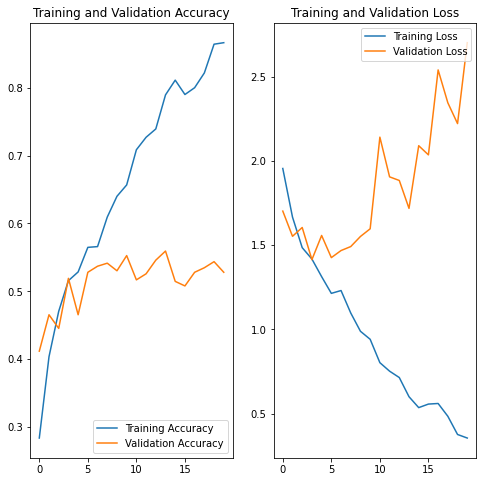

In [22]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

**Todo: Write your findings after the model fit, see if there is an evidence of model overfit or underfit**

**OBSERVATIONS:**
1.training datasety has accuracy 86%

2.validation set accuracy is 52%

3.model seems to be **overfitting**


# Data Augmentation

Apply data augmentation strategy to counter overfitting

In [23]:
# Todo, after you have analysed the model fit history for presence of underfit or overfit, choose an appropriate data augumentati, 
data_augmentation = keras.Sequential(
  [
    layers.experimental.preprocessing.RandomFlip("horizontal_and_vertical", 
                                                 input_shape=(img_height, 
                                                              img_width,
                                                              3)),
    #layers.experimental.preprocessing.RandomRotation(0.6),
    layers.experimental.preprocessing.RandomZoom(height_factor=(-0.1, 0.1), width_factor=(-0.1, 0.1), fill_mode='constant'),
  ]
)

In [24]:
# Add the image to a batch.
image = tf.cast(tf.expand_dims(images[0], 0), tf.float32)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


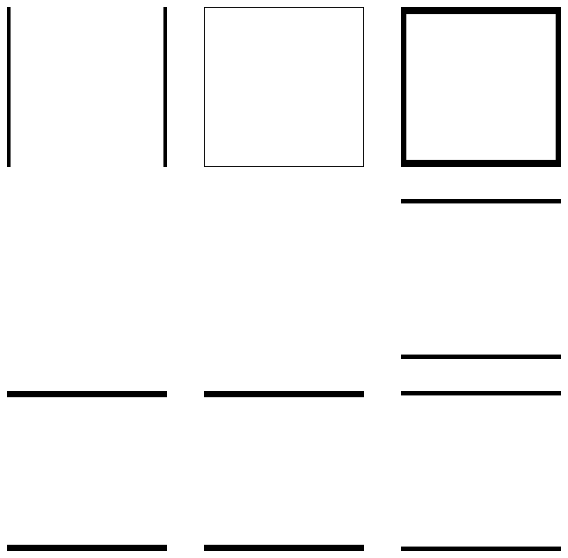

In [25]:
plt.figure(figsize=(10, 10))
for i in range(9):
  augmented_image = data_augmentation(image)
  ax = plt.subplot(3, 3, i + 1)
  plt.imshow(augmented_image[0])
  plt.axis("off")

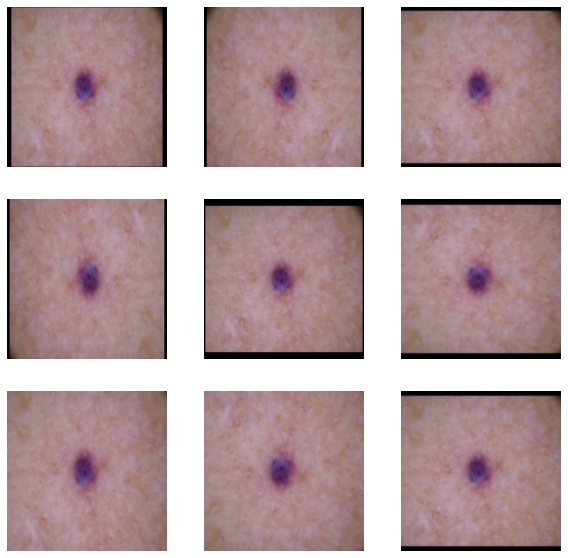

In [26]:
# Todo, visualize how your augmentation strategy works for one instance of training image.
plt.figure(figsize=(10, 10))
for images, _ in train_ds.take(1):
  for i in range(9):
    augmented_images = data_augmentation(images)
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(augmented_images[0].numpy().astype("uint8"))
    plt.axis("off")

# create model-3
after applying Data Augmentation and using Dropout layer

In [27]:
## You can use Dropout layer if there is an evidence of overfitting in your findings
num_classes=9
model = Sequential([
  data_augmentation,
  layers.experimental.preprocessing.Rescaling(1./255),
  layers.Conv2D(16, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(32, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(64, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Dropout(0.2),
  layers.Flatten(),
  layers.Dense(128, activation='relu'),
  layers.Dense(num_classes)
])

# Compiling the model-3

In [28]:
## Your code goes here
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

# Training the model-3

In [29]:
## Your code goes here, note: train your model for 20 epochs
epochs = 20
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/20
56/56 [==============================] - 4s 55ms/step - loss: 2.0087 - accuracy: 0.2679 - val_loss: 1.8310 - val_accuracy: 0.3333
Epoch 2/20
56/56 [==============================] - 3s 52ms/step - loss: 1.8000 - accuracy: 0.3426 - val_loss: 1.7266 - val_accuracy: 0.3647
Epoch 3/20
56/56 [==============================] - 3s 52ms/step - loss: 1.5896 - accuracy: 0.4241 - val_loss: 1.6729 - val_accuracy: 0.4004
Epoch 4/20
56/56 [==============================] - 3s 52ms/step - loss: 1.5069 - accuracy: 0.4654 - val_loss: 1.4897 - val_accuracy: 0.4855
Epoch 5/20
56/56 [==============================] - 3s 51ms/step - loss: 1.4299 - accuracy: 0.5039 - val_loss: 1.4061 - val_accuracy: 0.5235
Epoch 6/20
56/56 [==============================] - 3s 54ms/step - loss: 1.3952 - accuracy: 0.5123 - val_loss: 1.3871 - val_accuracy: 0.5235
Epoch 7/20
56/56 [==============================] - 3s 52ms/step - loss: 1.3305 - accuracy: 0.5140 - val_loss: 1.3448 - val_accuracy: 0.5347
Epoch 8/20
56

# Visualizing the results FOR MODEL-3

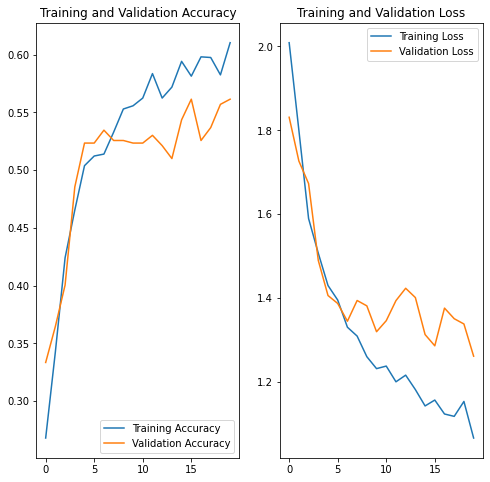

In [30]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

OBSERVATIONS:

1.Data Augmentation strategy seems to solve overfitting problem in  model

2.Training accuracy is 61% and validation accuracy is 56%

3.There seems to be improvement in validation loss and validation accuracy.





In [31]:
# For convenience, let us set up the path for the training and validation sets
train_dir = os.path.join('/content/gdrive/MyDrive/Skin cancer ISIC The International Skin Imaging Collaboration/Train')
val_dir = os.path.join('/content/gdrive/MyDrive/Skin cancer ISIC The International Skin Imaging Collaboration/Test')

In [32]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
# Setting batch size and image size
batch_size = 100
IMG_SHAPE = 224 

# Create training images generator
#Generate batches of tensor image data with real-time data augmentation.
#https://www.tensorflow.org/api_docs/python/tf/keras/preprocessing/image/ImageDataGenerator
image_gen_train = ImageDataGenerator(
                    rescale=1./255,
                    rotation_range=45,
                    width_shift_range=.15,
                    height_shift_range=.15,
                    horizontal_flip=True,
                    vertical_flip=True,
                    zoom_range=0.5
                    )
#https://keras.io/api/preprocessing/image/
#Then calling image_dataset_from_directory(main_directory, labels='inferred') will return a tf.data.Dataset that yields batches of images from the subdirectories
train_data_gen = image_gen_train.flow_from_directory(
                                                batch_size=batch_size,
                                                directory=train_dir,
                                                shuffle=True,
                                                target_size=(IMG_SHAPE,IMG_SHAPE),
                                                class_mode='sparse'
                                                )

# Create validation images generator
image_gen_val = ImageDataGenerator(rescale=1./255)
val_data_gen = image_gen_val.flow_from_directory(batch_size=batch_size,
                                                 directory=val_dir,
                                                 target_size=(IMG_SHAPE, IMG_SHAPE),
                                                 class_mode='sparse')

Found 2239 images belonging to 9 classes.
Found 118 images belonging to 9 classes.


In [33]:
#Create a CNN model
#Experiment #1
#A Sequential model is appropriate for a plain stack of layers where each layer has exactly one input tensor and one output tensor
import numpy as np
import glob
import shutil
import matplotlib.pyplot as plt

# Import layers explicitly to keep our code compact
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Conv2D, Flatten, Dropout, MaxPooling2D


model = Sequential()

#2D convolution layer (e.g. spatial convolution over images).
model.add(Conv2D(16, 3, padding='same', activation='relu', input_shape=(IMG_SHAPE,IMG_SHAPE, 3)))
#Downsamples the input along its spatial dimensions (height and width) by taking the maximum value over an input window (of size defined by pool_size) for each channel of the input. 
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(32, 3, padding='same', activation='relu'))

#Downsamples the input along its spatial dimensions (height and width) by taking the maximum value over an input window (of size defined by pool_size) for each channel of the input. 
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(64, 3, padding='same', activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

#Flattens the input. Does not affect the batch size.
model.add(Flatten())

#https://keras.io/api/layers/regularization_layers/dropout/
#The Dropout layer randomly sets input units to 0 with a frequency of rate at each step during training time, which helps prevent overfitting. Inputs not set to 0 are scaled up by 1/(1 - rate) such that the sum over all inputs is unchanged
model.add(Dropout(0.2))
model.add(Dense(512, activation='relu'))

model.add(Dropout(0.2))

#Just your regular densely-connected NN layer.
#Dense is the only actual network layer in that model. A Dense layer feeds all outputs from the previous layer to all its neurons, each neuron providing one output to the next layer.
#It's the most basic layer in neural networks. A Dense(10) has ten neurons. A Dense(512) has 512 neurons.
#Dense implements the operation: output = activation(dot(input, kernel)
model.add(Dense(9))

# Compile the model
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

# Train the model
epochs = 20

history = model.fit(
  train_data_gen,
  validation_data=val_data_gen,
  epochs=epochs
)

Epoch 1/20
23/23 [==============================] - 118s 5s/step - loss: 2.5393 - accuracy: 0.2108 - val_loss: 2.1174 - val_accuracy: 0.2288
Epoch 2/20
23/23 [==============================] - 72s 3s/step - loss: 1.8270 - accuracy: 0.3323 - val_loss: 2.2840 - val_accuracy: 0.1864
Epoch 3/20
23/23 [==============================] - 73s 3s/step - loss: 1.5872 - accuracy: 0.4176 - val_loss: 2.1565 - val_accuracy: 0.2881
Epoch 4/20
23/23 [==============================] - 77s 3s/step - loss: 1.4814 - accuracy: 0.4681 - val_loss: 2.4585 - val_accuracy: 0.2966
Epoch 5/20
23/23 [==============================] - 74s 3s/step - loss: 1.4316 - accuracy: 0.4886 - val_loss: 2.3962 - val_accuracy: 0.3390
Epoch 6/20
23/23 [==============================] - 74s 3s/step - loss: 1.4581 - accuracy: 0.4935 - val_loss: 2.0848 - val_accuracy: 0.2966
Epoch 7/20
23/23 [==============================] - 77s 3s/step - loss: 1.3783 - accuracy: 0.5141 - val_loss: 2.1381 - val_accuracy: 0.3475
Epoch 8/20
23/23 [=

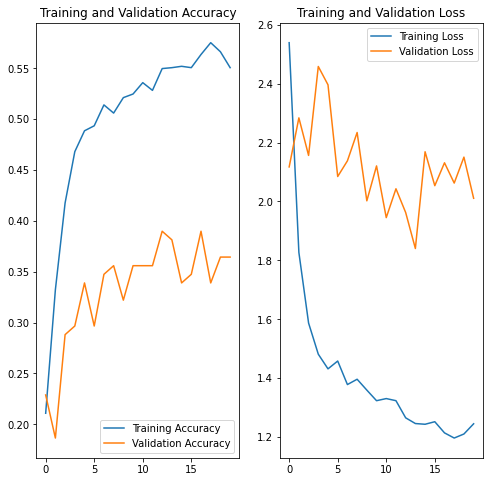

In [34]:
import matplotlib.pyplot as plt
epochs=20
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)



plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

**TO DO:**

**OBSERVATIONS:**

1.training accuracy is 55%

2.validation accuracy is 36%

3.model seems poor performing.


# class imbalance

In [35]:
## Your code goes here.
from glob import glob
path_list = [x for x in glob(os.path.join(data_dir_train, '*', '*.jpg'))]
lesion_list = [os.path.basename(os.path.dirname(y)) for y in glob(os.path.join(data_dir_train, '*', '*.jpg'))]
len(path_list)

2239

In [36]:
dataframe_dict_original = dict(zip(path_list, lesion_list))
original_df = pd.DataFrame(list(dataframe_dict_original.items()),columns = ['Path','Label'])
original_df

,Path,Label
0,/content/gdrive/MyDrive/Skin cancer ISIC The I...,vascular lesion
1,/content/gdrive/MyDrive/Skin cancer ISIC The I...,vascular lesion
2,/content/gdrive/MyDrive/Skin cancer ISIC The I...,vascular lesion
3,/content/gdrive/MyDrive/Skin cancer ISIC The I...,vascular lesion
4,/content/gdrive/MyDrive/Skin cancer ISIC The I...,vascular lesion
...,...,...
2234,/content/gdrive/MyDrive/Skin cancer ISIC The I...,dermatofibroma
2235,/content/gdrive/MyDrive/Skin cancer ISIC The I...,dermatofibroma
2236,/content/gdrive/MyDrive/Skin cancer ISIC The I...,dermatofibroma
2237,/content/gdrive/MyDrive/Skin cancer ISIC The I...,dermatofibroma


Class=8, n=139 (6.208%)
Class=7, n=181 (8.084%)
Class=1, n=376 (16.793%)
Class=3, n=438 (19.562%)
Class=4, n=357 (15.945%)
Class=0, n=114 (5.092%)
Class=5, n=462 (20.634%)
Class=6, n=77 (3.439%)
Class=2, n=95 (4.243%)


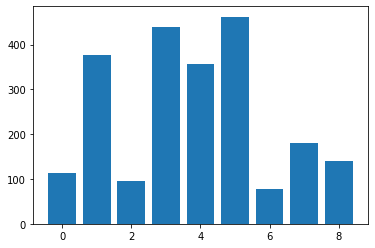

In [37]:
from sklearn.preprocessing import LabelEncoder
from collections import Counter
# split into input and output elements
X, y = original_df['Path'], original_df['Label']
# label encode the target variable
y = LabelEncoder().fit_transform(y)
# summarize distribution
counter = Counter(y)
for k,v in counter.items():
	per = v / len(y) * 100
	print('Class=%d, n=%d (%.3f%%)' % (k, v, per))
# plot the distribution
plt.bar(counter.keys(), counter.values())
plt.show()

### **Todo:**

**1> Write your findings here**:

ans:pigmented benign keratosis(462) has maximum samples
    
    Class=5,pigmented benign keratosis: 462 samples((20.634%))
    Class=3,melanoma: 438 samples(19.562%)
    Class=1,basal cell carcinoma: 376 samples(16.79%)
    Class=4,nevus: 357 samples(15.945%)
    Class=7,squamous cell carcinoma: 181 samples(8.084%)
    Class=8,,vascular lesion: 139 samples(6.208%)
    Class=0,actinic keratosis: 114 samples(5.092%)
    Class=2,dermatofibroma: 95 samples(4.243%)
    Class=6,seborrheic keratosis: 77(3.439%)



    

**2>Which class has the least number of samples?**

Ans:seborrheic keratosis(class-6): 77

**3>Which classes dominate the data in terms proportionate number of samples?**

Ans:-class-5=pigmented benign keratosis( 462 samples,20.63%) dominates the data


Todo: Rectify the class imbalance
Context: we can use a python package known as Augmentor 

In [38]:
!pip install Augmentor

In [39]:
path_to_training_dataset="/content/gdrive/MyDrive/Skin cancer ISIC The International Skin Imaging Collaboration/Train/"
import Augmentor
for i in class_names:
    p = Augmentor.Pipeline(path_to_training_dataset + i)
    p.rotate(probability=0.7, max_left_rotation=10, max_right_rotation=10)
    p.sample(500) ## We are adding 500 samples per class to make sure that none of the classes are sparse.

Initialised with 114 image(s) found.
Output directory set to /content/gdrive/MyDrive/Skin cancer ISIC The International Skin Imaging Collaboration/Train/actinic keratosis/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7F5604A1ED10>: 100%|██████████| 500/500 [00:24<00:00, 20.23 Samples/s]


Initialised with 376 image(s) found.
Output directory set to /content/gdrive/MyDrive/Skin cancer ISIC The International Skin Imaging Collaboration/Train/basal cell carcinoma/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7F5604A47FD0>: 100%|██████████| 500/500 [00:26<00:00, 18.62 Samples/s]


Initialised with 95 image(s) found.
Output directory set to /content/gdrive/MyDrive/Skin cancer ISIC The International Skin Imaging Collaboration/Train/dermatofibroma/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7F558ED71610>: 100%|██████████| 500/500 [00:26<00:00, 19.00 Samples/s]


Initialised with 438 image(s) found.
Output directory set to /content/gdrive/MyDrive/Skin cancer ISIC The International Skin Imaging Collaboration/Train/melanoma/output.

Processing <PIL.Image.Image image mode=RGB size=3072x2304 at 0x7F560469BDD0>: 100%|██████████| 500/500 [01:50<00:00,  4.54 Samples/s]


Initialised with 357 image(s) found.
Output directory set to /content/gdrive/MyDrive/Skin cancer ISIC The International Skin Imaging Collaboration/Train/nevus/output.

Processing <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=3072x2304 at 0x7F5604A2D510>: 100%|██████████| 500/500 [01:42<00:00,  4.88 Samples/s]


Initialised with 462 image(s) found.
Output directory set to /content/gdrive/MyDrive/Skin cancer ISIC The International Skin Imaging Collaboration/Train/pigmented benign keratosis/output.

Processing <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=600x450 at 0x7F5605119690>: 100%|██████████| 500/500 [00:23<00:00, 20.92 Samples/s]


Initialised with 77 image(s) found.
Output directory set to /content/gdrive/MyDrive/Skin cancer ISIC The International Skin Imaging Collaboration/Train/seborrheic keratosis/output.

Processing <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=1024x768 at 0x7F5604626610>: 100%|██████████| 500/500 [00:51<00:00,  9.64 Samples/s]


Initialised with 181 image(s) found.
Output directory set to /content/gdrive/MyDrive/Skin cancer ISIC The International Skin Imaging Collaboration/Train/squamous cell carcinoma/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7F558ED8D0D0>: 100%|██████████| 500/500 [00:21<00:00, 22.94 Samples/s]


Initialised with 139 image(s) found.
Output directory set to /content/gdrive/MyDrive/Skin cancer ISIC The International Skin Imaging Collaboration/Train/vascular lesion/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7F5681553950>: 100%|██████████| 500/500 [00:21<00:00, 22.90 Samples/s]


Augmentor has stored the augmented images in the output sub-directory of each of the sub-directories of skin cancer types.. Lets take a look at total count of augmented images.

In [40]:
image_count_train = len(list(data_dir_train.glob('*/output/*.jpg')))
print(image_count_train)

4500


In [41]:
path_list_new = [x for x in glob(os.path.join(data_dir_train, '*','output', '*.jpg'))]
path_list_new

['/content/gdrive/MyDrive/Skin cancer ISIC The International Skin Imaging Collaboration/Train/vascular lesion/output/vascular lesion_original_ISIC_0032775.jpg_eda902dc-488f-4f27-ba21-6a49df764688.jpg',
 '/content/gdrive/MyDrive/Skin cancer ISIC The International Skin Imaging Collaboration/Train/vascular lesion/output/vascular lesion_original_ISIC_0031093.jpg_5b83f265-1f76-4a2d-8bd8-da92389e3f3d.jpg',
 '/content/gdrive/MyDrive/Skin cancer ISIC The International Skin Imaging Collaboration/Train/vascular lesion/output/vascular lesion_original_ISIC_0032866.jpg_121f963b-d892-4234-8600-a86040cd8bfd.jpg',
 '/content/gdrive/MyDrive/Skin cancer ISIC The International Skin Imaging Collaboration/Train/vascular lesion/output/vascular lesion_original_ISIC_0031955.jpg_548a7f25-3dbc-41dc-97ad-0232b8a91ffb.jpg',
 '/content/gdrive/MyDrive/Skin cancer ISIC The International Skin Imaging Collaboration/Train/vascular lesion/output/vascular lesion_original_ISIC_0032890.jpg_3f77e4f4-2715-4d97-9f06-634a27493

In [42]:
lesion_list_new = [os.path.basename(os.path.dirname(os.path.dirname(y))) for y in glob(os.path.join(data_dir_train, '*','output', '*.jpg'))]
lesion_list_new

['vascular lesion',
 'vascular lesion',
 'vascular lesion',
 'vascular lesion',
 'vascular lesion',
 'vascular lesion',
 'vascular lesion',
 'vascular lesion',
 'vascular lesion',
 'vascular lesion',
 'vascular lesion',
 'vascular lesion',
 'vascular lesion',
 'vascular lesion',
 'vascular lesion',
 'vascular lesion',
 'vascular lesion',
 'vascular lesion',
 'vascular lesion',
 'vascular lesion',
 'vascular lesion',
 'vascular lesion',
 'vascular lesion',
 'vascular lesion',
 'vascular lesion',
 'vascular lesion',
 'vascular lesion',
 'vascular lesion',
 'vascular lesion',
 'vascular lesion',
 'vascular lesion',
 'vascular lesion',
 'vascular lesion',
 'vascular lesion',
 'vascular lesion',
 'vascular lesion',
 'vascular lesion',
 'vascular lesion',
 'vascular lesion',
 'vascular lesion',
 'vascular lesion',
 'vascular lesion',
 'vascular lesion',
 'vascular lesion',
 'vascular lesion',
 'vascular lesion',
 'vascular lesion',
 'vascular lesion',
 'vascular lesion',
 'vascular lesion',


In [43]:
dataframe_dict_new = dict(zip(path_list_new, lesion_list_new))

In [44]:
df2 = pd.DataFrame(list(dataframe_dict_new.items()),columns = ['Path','Label'])
new_df = original_df.append(df2)

In [45]:
new_df['Label'].value_counts()

pigmented benign keratosis    962
melanoma                      938
basal cell carcinoma          876
nevus                         857
squamous cell carcinoma       681
vascular lesion               639
actinic keratosis             614
dermatofibroma                595
seborrheic keratosis          577
Name: Label, dtype: int64

So, now we have added 500 images to all the classes to maintain some class balance. We can add more images as we want to improve training process.

## **Train the model on the data created using Augmentor**

In [46]:
batch_size = 32
img_height = 180
img_width = 180

In [47]:
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir_train,
  seed=123,
  validation_split = 0.2,
  subset = 'training', ## Todo choose the correct parameter value, so that only training data is refered to
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 6739 files belonging to 9 classes.
Using 5392 files for training.


In [48]:
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir_train,
  seed=123,
  validation_split = 0.2,
  subset = 'validation',## Todo choose the correct parameter value, so that only validation data is refered to,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 6739 files belonging to 9 classes.
Using 1347 files for validation.


## **Create final model (include normalization)**

In [49]:
AUTOTUNE = tf.data.experimental.AUTOTUNE

train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

model = Sequential([
  layers.experimental.preprocessing.Rescaling(1./255),
  layers.Conv2D(16, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(32, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(64, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Dropout(0.2),
  layers.Flatten(),
  layers.Dense(128, activation='relu'),
  layers.Dense(num_classes)
])

### **Compile final model (Choose optimizer and loss function appropriately)**

In [50]:
## your code goes here
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

### **Train your model**

In [51]:
epochs = 20
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/20
169/169 [==============================] - 43s 89ms/step - loss: 1.9123 - accuracy: 0.2780 - val_loss: 1.5820 - val_accuracy: 0.3734
Epoch 2/20
169/169 [==============================] - 8s 46ms/step - loss: 1.4462 - accuracy: 0.4499 - val_loss: 1.4386 - val_accuracy: 0.4566
Epoch 3/20
169/169 [==============================] - 8s 47ms/step - loss: 1.2814 - accuracy: 0.5206 - val_loss: 1.2313 - val_accuracy: 0.5509
Epoch 4/20
169/169 [==============================] - 8s 45ms/step - loss: 1.1301 - accuracy: 0.5764 - val_loss: 1.1088 - val_accuracy: 0.5924
Epoch 5/20
169/169 [==============================] - 8s 45ms/step - loss: 0.9948 - accuracy: 0.6419 - val_loss: 1.1148 - val_accuracy: 0.5999
Epoch 6/20
169/169 [==============================] - 8s 46ms/step - loss: 0.8104 - accuracy: 0.7059 - val_loss: 0.8891 - val_accuracy: 0.6771
Epoch 7/20
169/169 [==============================] - 8s 45ms/step - loss: 0.7009 - accuracy: 0.7491 - val_loss: 0.7592 - val_accuracy: 0.721

### **Visualize the model results**

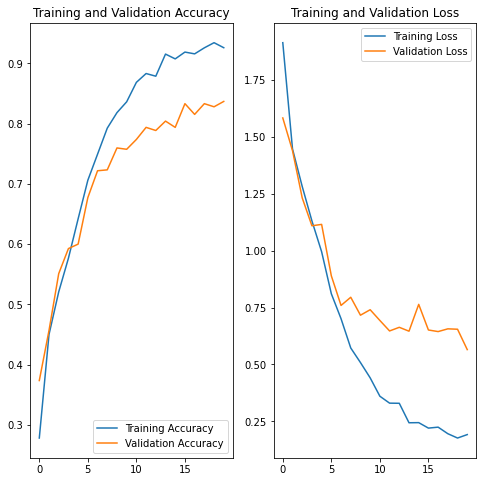

In [52]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

### **Todo: Analyze your results here. Did you get rid of underfitting/overfitting? Did class rebalance help?**

## Observations:

yes,data rebalance helped in improving the performance of final model.

1.training accuracy is 92% and validation accuracy is 82%

2.there is significant improvement in both accuracy and loss